In [3]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)

!rm -rf ./logs/ 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Autoencoder

An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name. Several variants exist to the basic model, with the aim of forcing the learned representations of the input to assume useful properties. Examples are the regularized autoencoders (Sparse, Denoising and Contractive autoencoders), proven effective in learning representations for subsequent classification tasks, and Variational autoencoders, with their recent applications as generative models. Autoencoders are effectively used for solving many applied problems, from face recognition to acquiring the semantic meaning of words.

An autoencoder is a neural network that learns to copy its input to its output. It has an internal (hidden) layer that describes a code used to represent the input, and it is constituted by two main parts: an encoder that maps the input into the code, and a decoder that maps the code to a reconstruction of the original input.

Performing the copying task perfectly would simply duplicate the signal, and this is why autoencoders usually are restricted in ways that force them to reconstruct the input approximately, preserving only the most relevant aspects of the data in the copy.

## Autoencoder architecture

The simplest form of an autoencoder is a feedforward, non-recurrent neural network similar to single layer perceptrons that participate in multilayer perceptrons (MLP) – having an input layer, an output layer and one or more hidden layers connecting them – where the output layer has the same number of nodes (neurons) as the input layer, and with the purpose of reconstructing its inputs (minimizing the difference between the input and the output) instead of predicting the target value $y$ given inputs $X$. Therefore, autoencoders are unsupervised learning models (do not require labeled inputs to enable learning).

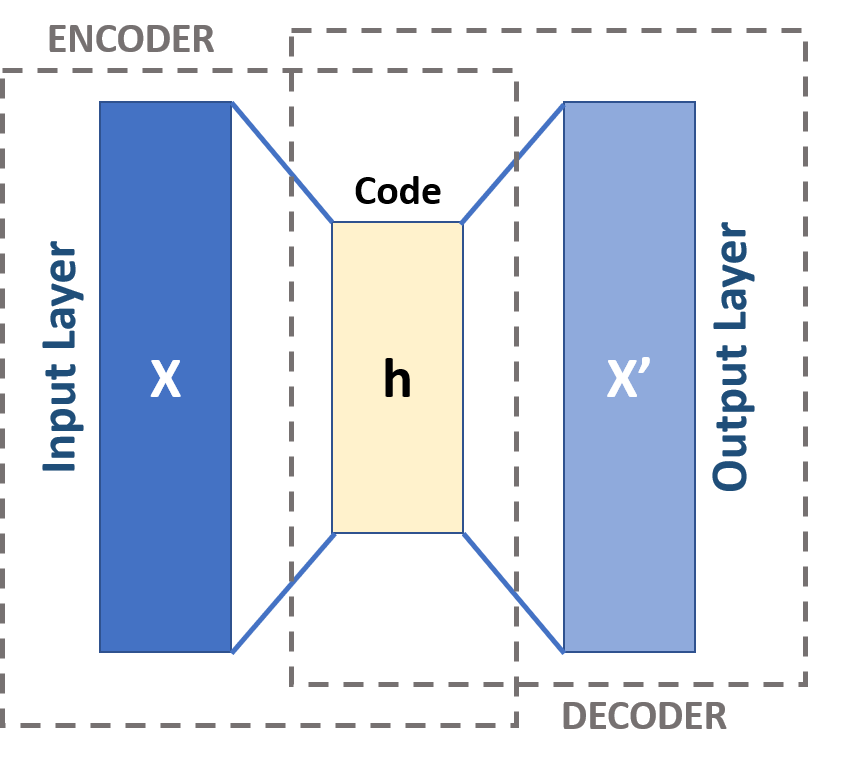

An autoencoder consists of two parts:
* the **encoder** $\phi$ maps the input down to a lower dimensional encoding (feature space)
* the **decoder** $\psi$ maps the low-dimensional encoding up to the original input dimensions

$$ \phi : \mathcal{X} \rightarrow \mathcal{F} $$
$$ \psi : \mathcal{F} \rightarrow \mathcal{X} $$
$$ \phi,\psi = \underset{\phi,\psi}{\operatorname{arg\,min}}\, \|X-(\psi \circ \phi) X\|^2 $$

Should the feature space $\mathcal{F}$ have lower dimensionality than the input space $\mathcal{X}$, the feature vector $\phi (x)$ can be regarded as a compressed representation of the input $x$. This is the case of undercomplete autoencoders. If the hidden layers are larger than (overcomplete autoencoders), or equal to, the input layer, or the hidden units are given enough capacity, an autoencoder can potentially learn the identity function and become useless. However, experimental results have shown that autoencoders might still learn useful features in these cases. In the ideal setting, one should be able to tailor the code dimension and the model capacity on the basis of the complexity of the data distribution to be modeled. One way to do so, is to exploit the model variants known as *Regularized Autoencoders*.

Autoencoders importantly are data-specific, which means that they will only be able to compress data similar to what they have been trained on. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

## Advantages of Depth

Autoencoders are often trained with only a single layer encoder and a single layer decoder, but using deep encoders and decoders offers many advantages.

* Depth can exponentially reduce the computational cost of representing some functions.
* Depth can exponentially decrease the amount of training data needed to learn some functions.
* Experimentally, deep autoencoders yield better compression compared to shallow or linear autoencoders.

## Convolutional Autoencoders

If our data is images, in pratice using convolutioanl neural networks (ConvNets) as encoders and decoders performs much better than fully connected layers. Here we use a analagous reverse of a Convolutional layer, a de-convolutional layers to upscale from the low-dimensional encoding up to the image original dimensions.

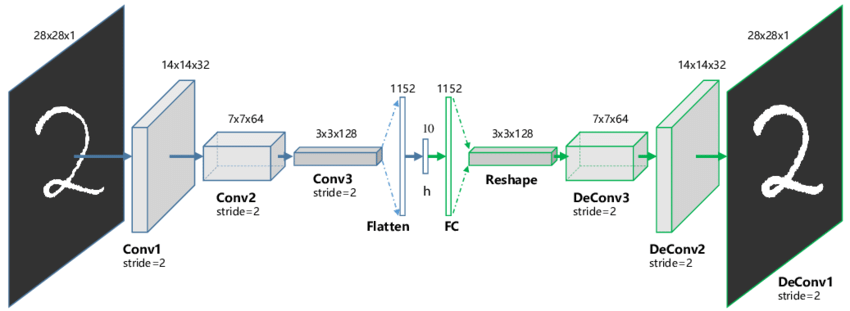

### Deconvolution layer 

Deconvolution is also more commonly known as a Transposed convolution layer. In Keras is is `tf.keras.layers.Conv2DTranspose`. It has the same parameters and keyword arguments as the convolution layer. That is:
* `filters`: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
* `kernel_size`: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window (receptive field). Can be a single integer to specify the same value for all spatial dimensions.
* `strides`: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions.
* `padding`: One of "valid", or "same" (case-insensitive). "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.

### Up Sampling layer

To up sample, we use the layer, most commonly to double the spatial size of the input $3D$ volume. In Keras this is `tf.keras.layers.UpSampling2D`, which takes the following keyword arguments:
* `size`: Int, or tuple of 2 integers. The upsampling factors for rows and columns (degfaults to (2,2)).
* `data_format`: A string, one of channels_last (default) or channels_first. The ordering of the dimensions in the inputs. channels_last corresponds to inputs with shape (batch, height, width, channels) while channels_first corresponds to inputs with shape (batch, channels, height, width). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be "channels_last".
* `interpolation`: A string, one of nearest or bilinear.


### Example

Lets train a convolutional autoencoder on the MNIST dataset

In [19]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Load the data, split between train and test sets
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print('Training images shape: ', x_train.shape)
print('Testing images shape: ', x_test.shape)

# Create the autoencoder model
# Create the encoder
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_input)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoder_output = MaxPooling2D((2, 2), padding='same')(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

# Create the decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder_output)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoder_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='convolutional_autoencoder')
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = autoencoder.fit(x_train, x_train,
                epochs=15,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[early_stop])

Training images shape:  (60000, 28, 28, 1)
Testing images shape:  (10000, 28, 28, 1)
Model: "convolutional_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 8)           584       
______________________

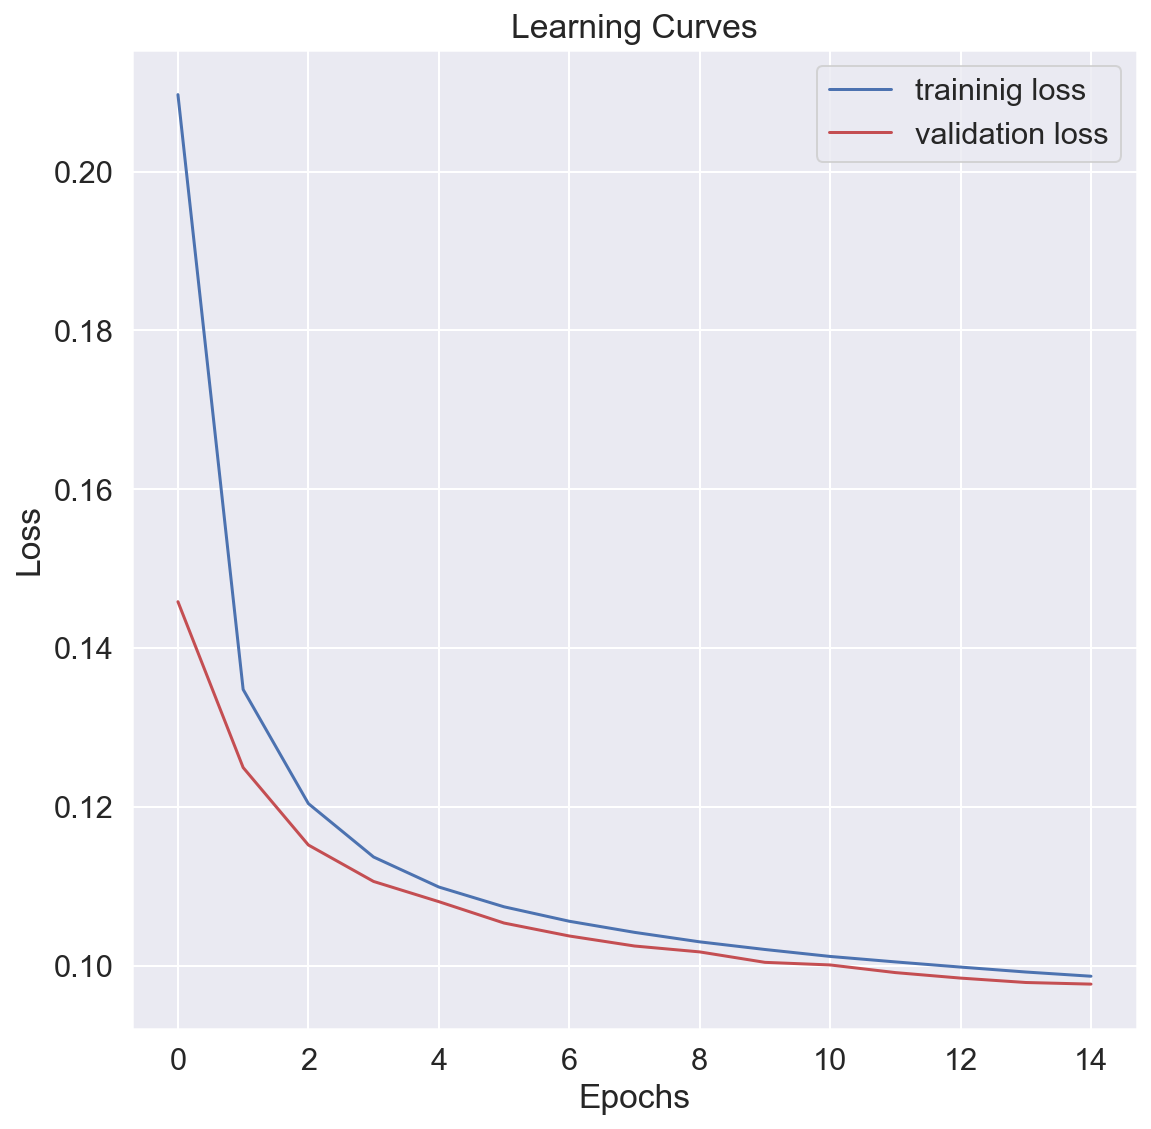

In [32]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
fig = plt.Figure(figsize=(4, 3))

epochs_to_mean = 1

plt.plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
plt.plot(history_df['val_loss'].rolling(epochs_to_mean).mean(), '-r')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['traininig loss', 'validation loss'])

Lets view the reconstructed digit images. Here the top line is the original image, and the bottom line is that reconstructed image from the output of autoencoder

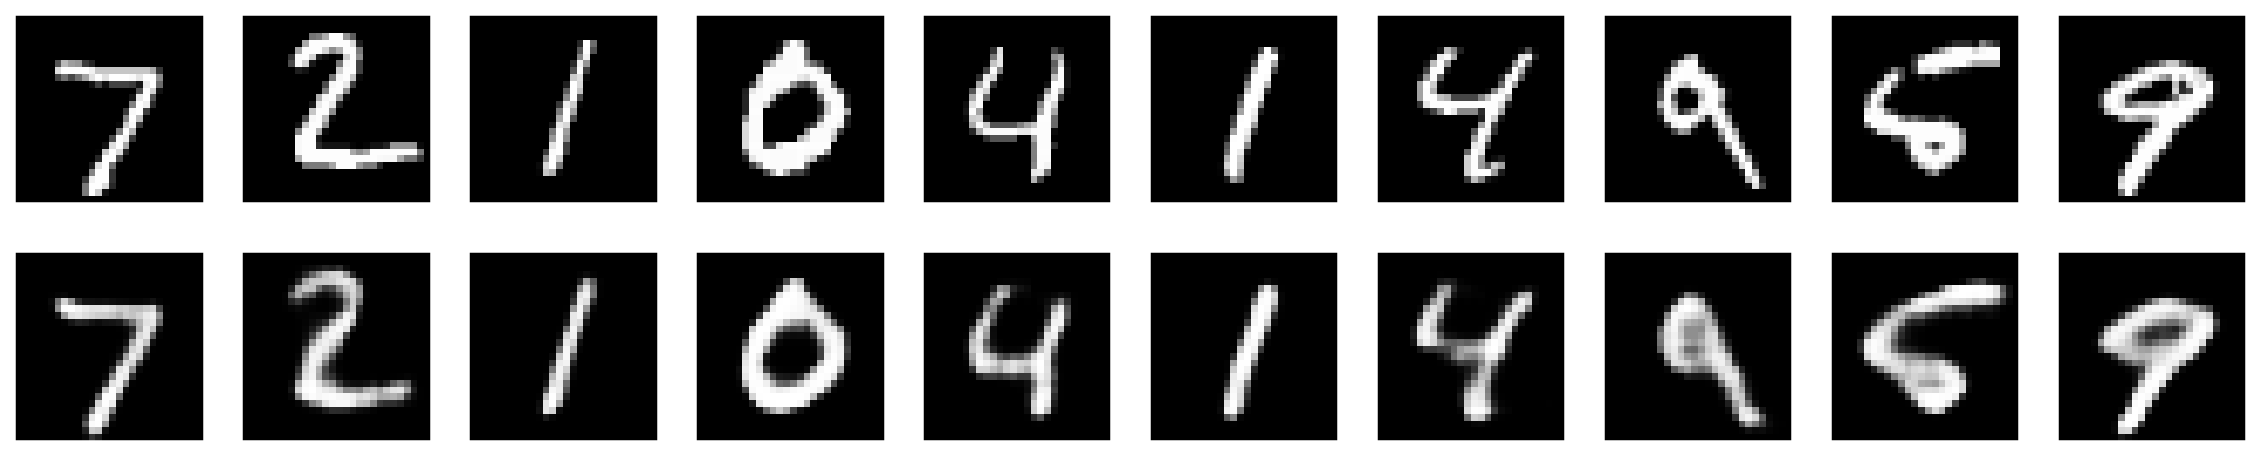

In [35]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Denoising Convolutional Autoencoder

One advantage of an autoencoder is that it is able to learn a denoising function, such as taking a partially corrupted input and outputting a cleaned output. This assumes that higher level representations are relatively stable and robust to the corruption of the input and that the model needs to extract features that capture useful structure in the distribution of the input.

Corruption of the input is performed only during the training phase of the autoencoder. Once the model has learnt the optimal parameters, in order to extract the representations from the original data no corruption is added.

Lets look at how to do this in Keras. We can generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [36]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

We can see what the noisy digits look like

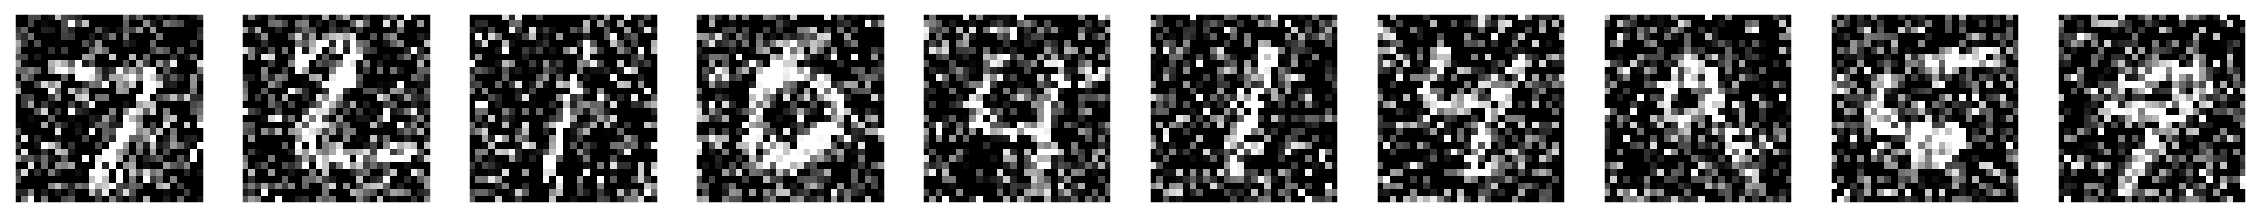

In [37]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Let construct a convolutional autoencoder again, however this time adding more filters per layer, and train it

In [38]:
# Create the autoencoder model
# Create the encoder
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoder_output = MaxPooling2D((2, 2), padding='same')(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

# Create the decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_output)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoder_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='convolutional_autoencoder')
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = autoencoder.fit(x_train_noisy, x_train,
                epochs=15,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[early_stop])

Model: "convolutional_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 14, 1

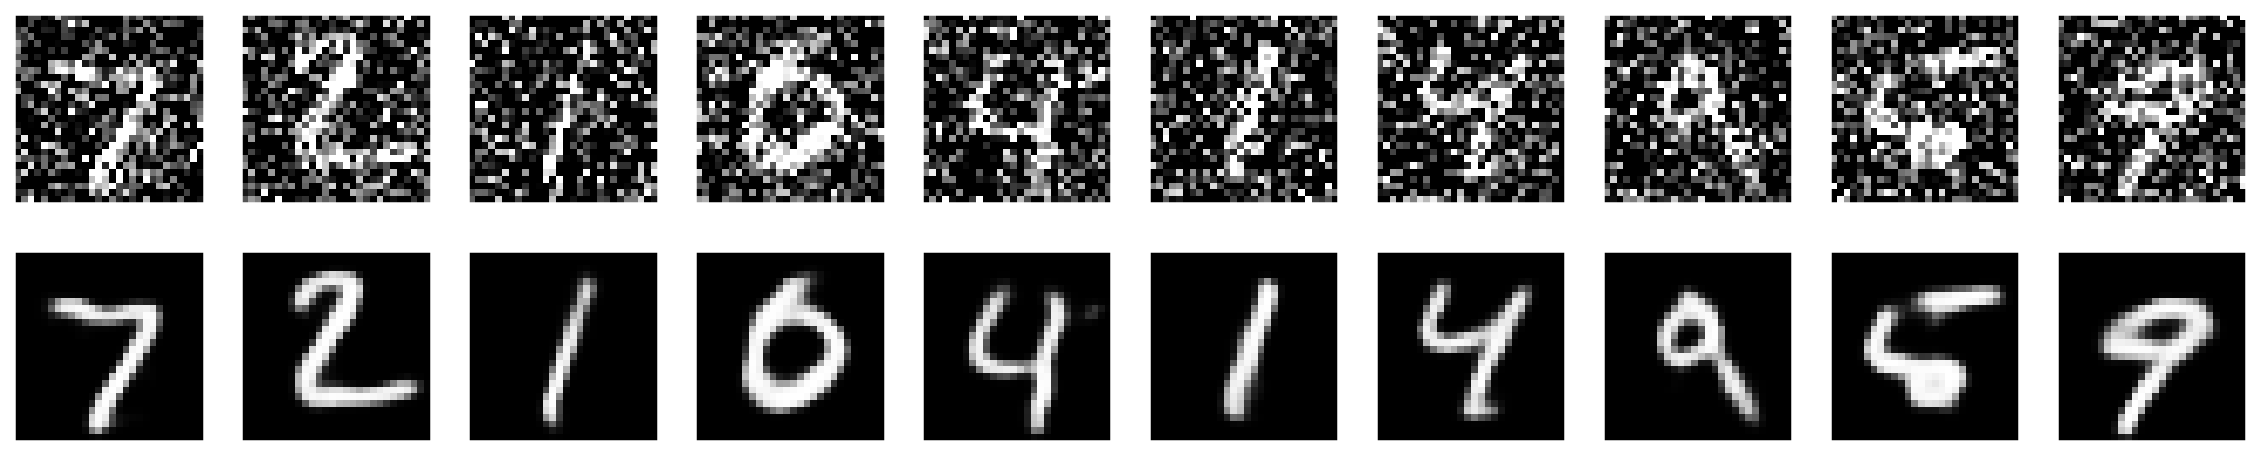

In [41]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can also scale this process to a bigger convnet which is useful for applications suhc as document denoising or audio denoising models.

## Variational autoencoder (VAE)

Unlike classical (sparse, denoising, etc.) autoencoders, Variational autoencoders (VAEs) are **generative model**'s, like Generative Adversarial Networks. Their association with this group of models derives mainly from the architectural affinity with the basic autoencoder (the final training objective has an encoder and a decoder), but their mathematical formulation differs significantly. VAEs are directed probabilistic graphical models (DPGM) whose posterior is approximated by a neural network, forming an autoencoder-like architecture. Differently from discriminative modeling that aims to learn a predictor given the observation, **generative modeling** tries to simulate how the data is generated, in order to understand the underlying causal relations. Causal relations have indeed the great potential of being generalizable.

Variational autoencoder models make strong assumptions concerning the distribution of *latent variables*. They use a variational approach for latent representation learning, which results in an additional loss component and a specific estimator for the training algorithm called the Stochastic Gradient Variational Bayes (SGVB) estimator. It assumes that the data is generated by a directed graphical model $p_\theta(\mathbf{x}|\mathbf{h})$ and that the encoder is learning an approximation $q_{\phi}(\mathbf{h}|\mathbf{x})$ to the posterior distribution $p_{\theta}(\mathbf{h}|\mathbf{x})$ where $\mathbf{\phi}$ and $\mathbf{\theta}$ denote the parameters of the encoder (recognition model) and decoder (generative model) respectively. The probability distribution of the latent vector of a VAE typically matches that of the training data much closer than a standard autoencoder. The objective of VAE has the following form:

$$\mathcal{L}(\mathbf{\phi},\mathbf{\theta},\mathbf{x})=D_{\mathrm{KL}}(q_{\phi}(\mathbf{h}|\mathbf{x})\Vert p_{\theta}(\mathbf{h}))-\mathbb{E}_{q_{\phi}(\mathbf{h}|\mathbf{x})}\big(\log p_{\theta}(\mathbf{x}|\mathbf{h})\big)$$

Here, $D_{\mathrm{KL}}$ stands for the *Kullback–Leibler divergence*. The prior over the latent variables is usually set to be the centred isotropic multivariate Gaussian $p_{\theta}(\mathbf{h})=\mathcal{N}(\mathbf{0,I})$; however, alternative configurations have been considered.

Commonly, the shape of the variational and the likelihood distributions are chosen such that they are factorized Gaussians:

$$
\begin{align}
q_{\phi}(\mathbf{h}|\mathbf{x}) &= \mathcal{N}(\boldsymbol{\rho}(\mathbf{x}), \boldsymbol{\omega}^2(\mathbf{x})\mathbf{I}), \\
p_{\theta}(\mathbf{x}|\mathbf{h}) &= \mathcal{N}(\boldsymbol{\mu}(\mathbf{h}), \boldsymbol{\sigma}^2(\mathbf{h})\mathbf{I}),
\end{align}
$$

where $ \boldsymbol{\rho}(\mathbf{x}) $ and  $\boldsymbol{\omega}^2(\mathbf{x}) $ are the encoder outputs, while $ \boldsymbol{\mu}(\mathbf{h}) $ and  $\boldsymbol{\sigma}^2(\mathbf{h}) $ are the decoder outputs.
This choice is justified by the simplifications that it produces when evaluating both the KL divergence and the likelihood term in variational objective defined above.

VAE have been criticized because they generate blurry images. However, researchers employing this model were showing only the mean of the distributions, $ \boldsymbol{\mu}(\mathbf{h}) $, rather than a sample of the learned Gaussian distribution

$$ \mathbf{x} \sim \mathcal{N}(\boldsymbol{\mu}(\mathbf{h}), \boldsymbol{\sigma}^2(\mathbf{h})\mathbf{I}) $$

These samples were shown to be overly noisy due to the choice of a factorized Gaussian distribution. Employing a Gaussian distribution with a full covariance matrix,

$$ p_{\theta}(\mathbf{x}|\mathbf{h}) = \mathcal{N}(\boldsymbol{\mu}(\mathbf{h}), \boldsymbol{\Sigma}(\mathbf{h})) $$

could solve this issue, but is computationally intractable and numerically unstable, as it requires estimating a covariance matrix from a single data sample. However, later research showed that a restricted approach where the inverse matrix $ \boldsymbol{\Sigma}^{-1}(\mathbf{h}) $ is sparse, could be tractably employed to generate images with high-frequency details.

### Example VAE in Keras


The VAE has a modular design. The encoder, decoder and VAE are 3 models that share weights. After training the VAE model, the encoder can be used to generate latent vectors. The decoder can be used to generate MNIST digits by sampling the latent vector from a Gaussian distribution with mean = 0 and std = 1.

In [119]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 20

Lets build our Encoder model, mapping inputs to our latent distribution parameters

In [120]:
# Encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

We can then use these parameters to sample new similar points from the latent space

In [121]:
def sampling(args):
    z_mean, z_log_sigma = args
    batch = keras.backend.shape(z_mean)[0]
    dim = keras.backend.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = keras.backend.random_normal(shape=(batch_size, latent_dim))
    return z_mean + keras.backend.exp(0.5 * z_log_sigma) * epsilon

z = keras.layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

Instantiate the encoder model

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_36[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_36[0][0]                   
____________________________________________________________________________________________

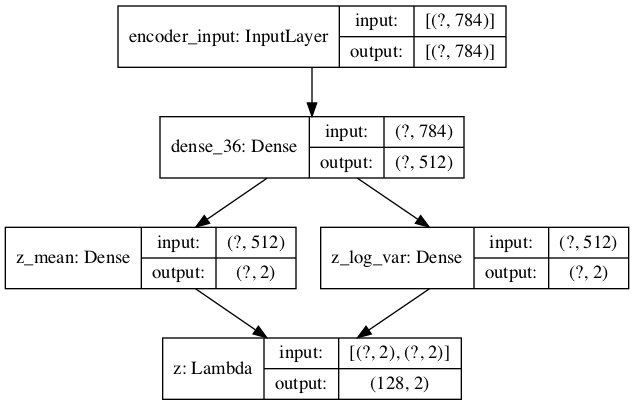

In [122]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
keras.utils.plot_model(encoder, show_shapes=True)

We can build the decoder, to map these sampled latent points back to reconstructed inputs

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_38 (Dense)             (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


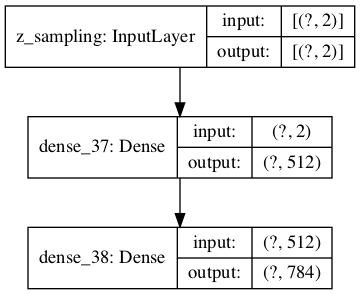

In [123]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
keras.utils.plot_model(decoder, show_shapes=True)

In [124]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Our three models are:
* **VAE** : an end-to-end autoencoder mapping inputs to reconstructions
* **Encoder**: mapping inputs to the latent space
* **Decoder**: (generator) that can take points on the latent space and will output the corresponding reconstructed samples

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 403972      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Model)                 multiple             403728      encoder[1][2]                    
__________________________________________________________________________________________________
tf_op_layer_clip_by_value_2/Min [(128, 784)]         0           decoder[1][0]                    
____________________________________________________________________________________________

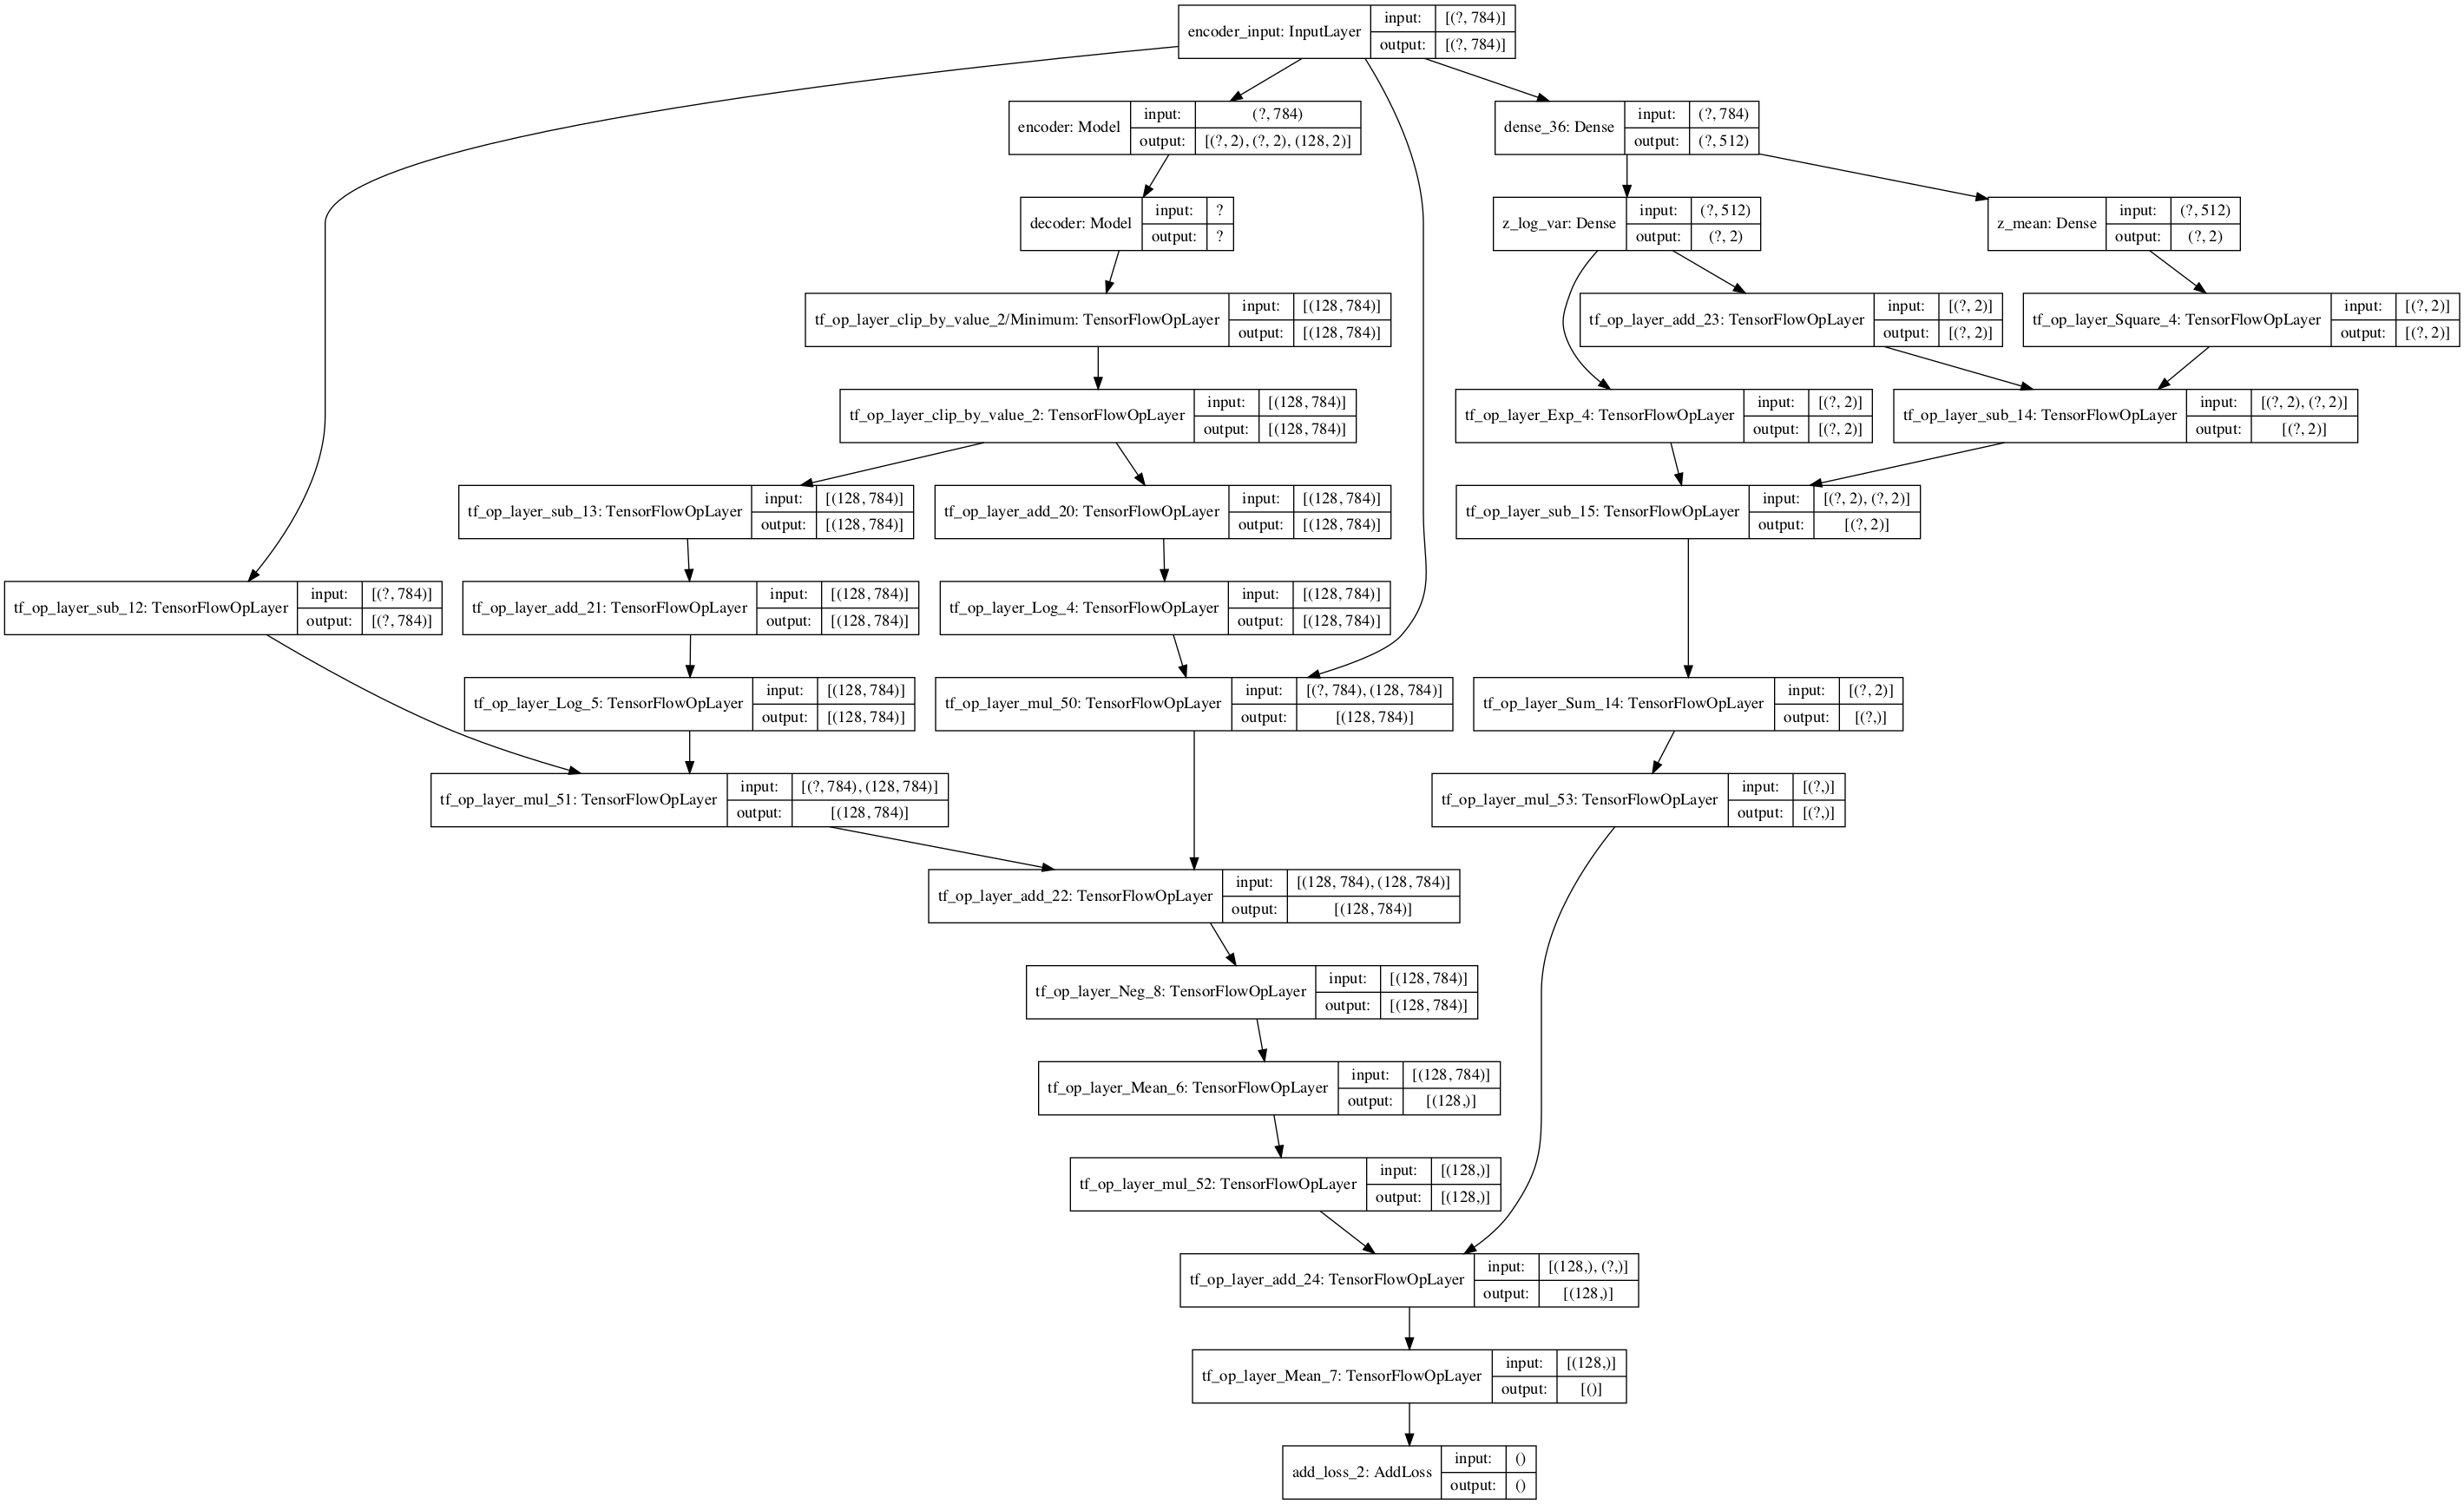

In [125]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - keras.backend.square(z_mean) - keras.backend.exp(z_log_var)
kl_loss = keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = keras.backend.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)

vae.compile(optimizer='adam')
vae.summary()
keras.utils.plot_model(vae, show_shapes=True)

In [126]:
history = vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 19s 321us/sample - loss: 197.4822


InvalidArgumentError: Incompatible shapes: [96,2] vs. [128,2] [Op:Mul] name: vae_mlp/encoder/z/mul/

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [100]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

NameError: name 'generator' is not defined